## Data Preparation

#### Check for duplicate PIDs in the dataset

In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../data/w1w2w3w4w5_indices_weights_jul12_2022.csv', low_memory=False)

# Check for duplicate PIDs
duplicate_pids = df[df.duplicated('PID', keep=False)]

if not duplicate_pids.empty:
    print("There are duplicate PIDs in the dataset.")
    duplicate_pids.to_csv('../data/duplicate_pids.csv', index=False)
    print("Duplicate PIDs have been saved to '../data/duplicate_pids.csv'.")
else:
    print("All PIDs are unique.")

There are duplicate PIDs in the dataset.
Duplicate PIDs have been saved to '../data/duplicate_pids.csv'.


⬆️ here we filter the participants who participated in more than one wave and we group the responses by the PID

---
#### Filter Wave Survey Data

In [2]:
# Load the CSV file
df = pd.read_csv("../data/duplicate_pids.csv", low_memory=False)

# Identify valid sequences (rolling window approach)
df['valid_seq'] = df['WAVE'].rolling(3).apply(lambda x: list(x) == [2,3,4], raw=True)

# Flag rows belonging to valid sequences
df['keep'] = df['valid_seq'].shift(-2).fillna(0).astype(bool) | df['valid_seq'].shift(-1).fillna(0).astype(bool) | df['valid_seq'].fillna(0).astype(bool)

# Filter the rows
filtered_df = df[df['keep']].drop(columns=['valid_seq', 'keep'])

# Save to a new CSV file
filtered_df.to_csv("../data/filtered_duplicate_pids.csv", index=False)

print("Filtered data saved to filtered_duplicate_pids.csv")

Filtered data saved to filtered_duplicate_pids.csv


⬆️ here we filter the participants who responded in waves 2 and 3 and 4 (in this order)

---
#### Likert Scale Standardization

In [3]:
# Load the CSV file from the data directory
df = pd.read_csv('../data/filtered_duplicate_pids.csv', low_memory=False)

# Some variables use a five-point Likert scale (1 to 5), while others use a four-point scale (1 to 4)
# Since some scales are missing a neutral category (like 3), we need to standardize them
# We chose to rescale the 1-4 scale to match the 1-5 scale by applying a linear transformation:
# 1 (Not at all)         → 1
# 2 (Only a little)      → 2.33
# 3 (A moderate amount)  → 3.67
# 4 (A great deal)       → 5
mapping = {1: 1, 2: 2.33, 3: 3.67, 4: 5}

# List of variables to be mapped
variables_to_map = ['cc4_world', 'cc4_wealthUS', 'cc4_poorUS', 'cc4_comm', 'cc4_famheal', 'cc4_famecon']

# Apply the mapping to the specified variables
for var in variables_to_map:
    df[var] = df[var].map(mapping)

# Save the cleaned data to a new CSV file
df.to_csv('../data/likert_scale.csv', index=False)

print("Data has been standardized and saved to 'data/likert_scale.csv'.")

Data has been standardized and saved to 'data/likert_scale.csv'.


⬆️ here we rescale the 1-4 scale of some variables to match the 1-5 scale

---
#### Fill missing values

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from skimpy import skim  # Equivalent to skimr::skim() in R

# Load the dataset
df = pd.read_csv('../data/likert_scale.csv', low_memory=False)

# Define ccSolve columns in decreasing order of WTP
ccSolve_columns = ["ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0"]
cc_policy_columns = ["cc_pol_tax", "cc_pol_car"]

# Step 1: Fill downward (Lower WTP should be at least as approved as higher WTP)
for i in range(len(ccSolve_columns) - 1):  
    higher_col = ccSolve_columns[i]
    lower_col = ccSolve_columns[i + 1]

    # If lower response is missing but higher response exists, fill with gradual increase
    df[lower_col] = df[lower_col].fillna(df[higher_col] + 0.75)

# Step 2: Fill upward (Higher WTP should be less approved than lower WTP)
for i in range(len(ccSolve_columns) - 1, 0, -1):  
    lower_col = ccSolve_columns[i]
    higher_col = ccSolve_columns[i - 1]

    # If higher response is missing but lower response exists, fill with gradual decrease
    df[higher_col] = df[higher_col].fillna(df[lower_col] - 1.5)

# Step 3: Handle respondents with all missing `ccSolve` responses
# If all `ccSolve` values are missing for a respondent, fill with a neutral value (3)
df[ccSolve_columns] = df[ccSolve_columns].apply(lambda row: row.fillna(3) if row.isna().all() else row, axis=1)

# Step 4: Ensure values stay within 1-5
df[ccSolve_columns] = df[ccSolve_columns].clip(1, 5)

# Step 5: Fill missing values for cc_pol_tax and cc_pol_car with 3 (Neutral)
for cc_policy in cc_policy_columns:
    df[cc_policy] = df[cc_policy].fillna(3)

# Save the filled dataset
df.to_csv("../data/cleaned_data.csv", index=False)

⬆️ here we fill the missing values of some variables

## Data Description

The dataset consists of variables measuring **perceptions of climate change impact, support for policies, and willingness to pay (WTP) for climate solutions**

#### **Climate Change Perception Variables (`cc4_*`)**
- **`cc4_world`**: Perceived extent to which global warming is harming the world
- **`cc4_wealthUS`**: Perceived harm of climate change on wealthy communities in the U.S.
- **`cc4_poorUS`**: Perceived harm of climate change on poor communities in the U.S.
- **`cc4_comm`**: Perceived impact of climate change on local communities
- **`cc4_famheal`**: Perceived impact of climate change on family health
- **`cc4_famecon`**: Perceived impact of climate change on family economic well-being

#### **Willingness to Pay for Climate Solutions (`ccSolve*`)**
- **`ccSolve100`**: Support for climate policies if they cost **$100 per month**
- **`ccSolve50`**: Support for climate policies if they cost **$50 per month**
- **`ccSolve10`**: Support for climate policies if they cost **$10 per month**
- **`ccSolve1`**: Support for climate policies if they cost **$1 per month**
- **`ccSolve0`**: General support for climate policies **without specifying a cost**

#### **Climate Policy Support (`cc_pol_*`)**
- **`cc_pol_tax`**: Support for a **carbon tax** to reduce emissions
- **`cc_pol_car`**: Support for **stronger emissions standards for car manufacturers**

## Data Summary

In [5]:
# Load your dataset (replace 'your_data.csv' with your actual file)
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select only the relevant numeric variables
columns_of_interest = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0", "cc_pol_tax", "cc_pol_car"
]

df_selected = df[columns_of_interest]

# Drop non-numeric columns (if any) and check correlations
df_numeric = df_selected.select_dtypes(include=['number'])

# Display summary statistics (equivalent to skimr::skim())
skim(df_numeric)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5667   │ │ float64     │ 13    │                                                          │
│ │ Number of columns │ 13     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column            ┃ NA   ┃ NA %   ┃ mean    ┃ sd        ┃ p0  ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ cc4_world         │    0 │      0 │   3.628 │     1.326 │   1 │   2.33 │   3.67 │      5 │     5 │ ▂▅  ▇▇  │  │
│ │ cc4_wealthUS      │    0 │      0 │   2.781 │     1.347 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▆▇  ▆▃  │  │
│ │ cc4_poorUS        │    0 │      0 │   3.396 │     1.405 │   1 │   2.33 │   3.67 │      5 │     5 │ ▃▅  ▇▇  │  │
│ │ cc4_comm          │    0 │      0 │   2.952 │     1.318 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▅▇  ▇▅  │  │
│ │ cc4_famheal       │    0 │      0 │   2.682 │     1.347 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▇  ▆▃  │  │
│ │ cc4_famecon       │    0 │      0 │   2.278 │     1.362 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▅  ▃▂  │  │
│ │ ccSolve100        │    0 │      0 │   1.447 │    0.8836 │   1 │      1 │      1 │    1.5 │     5 │  ▇▁ ▁   │  │
│ │ ccSolve50         │    0 │      0 │   1.972 │     1.211 │   1 │      1 │    1.5 │   2.75 │     5 │ ▇▂▁▁▁▁  │  │
│ │ ccSolve10         │    0 │      0 │   2.672 │     1.374 │   1 │    1.5 │    2.5 │   3.75 │     5 │ ▇▃▃▃▃▅  │  │
│ │ ccSolve1          │    0 │      0 │    3.45 │     1.295 │   1 │    2.5 │    3.5 │   4.75 │     5 │ ▃▁▃▅▃▇  │  │
│ │ ccSolve0          │    0 │      0 │   4.094 │     1.066 │   1 │    3.5 │    4.5 │      5 │     5 │  ▁▁▂▃▇  │  │
│ │ cc_pol_tax        │    0 │      0 │   3.193 │     1.311 │   1 │      2 │      3 │      4 │     5 │ ▅▃ ▇▇▅  │  │
│ │ cc_pol_car        │    0 │      0 │   3.713 │     1.229 │   1 │      3 │      4 │      5 │     5 │ ▂▂ ▆▇▇  │  │
│ └───────────────────┴──────┴────────┴─────────┴───────────┴─────┴────────┴────────┴────────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### **1️⃣ Summary Statistics**
Each variable is described with:
- **Mean:** The average value
- **SD (Standard Deviation):** How spread out responses are
- **Min (p0) / Max (p100):** The range of responses
- **Quartiles (p25, p50, p75):** Percentiles of the distribution
- **Histogram:** A small visual representation of the distribution

---

#### **2️⃣ Climate Perception Variables (`cc4_*`)**
These variables measure **how much individuals believe climate change is affecting different groups and aspects of life**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|--------|--------|------|------|------|------|------|--------------|
| **`cc4_world`**   | `3.63`  | `1.33`  | `1`  | `2.33`  | `3.67`  | `5`  | `5`  | 🟦▅▇▇ |
| **`cc4_wealthUS`** | `2.78`  | `1.35`  | `1`  | `2.33`  | `2.33`  | `3.67`  | `5`  | 🟦▆▇▆▃ |
| **`cc4_poorUS`**   | `3.39`  | `1.41`  | `1`  | `2.33`  | `3.67`  | `5`  | `5`  | 🟦▃▅▇▇ |
| **`cc4_comm`**     | `2.95`  | `1.32`  | `1`  | `2.33`  | `2.33`  | `3.67`  | `5`  | 🟦▅▇▇▅ |

**📝 Key Insights**  
✅ **Most respondents believe climate change is harmful**, but there is some variation in perceived impact  
✅ **People believe climate change affects poor communities more (`cc4_poorUS = 3.39`) than wealthy ones (`cc4_wealthUS = 2.78`)**  
✅ **The highest concern is for global impact (`cc4_world = 3.63`)**  

---

#### **3️⃣ Willingness to Pay for Climate Policy (`ccSolve*`)**
These variables assess **how much financial support people are willing to contribute to climate policies**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|--------|--------|------|------|------|------|------|--------------|
| **`ccSolve100`**  | `1.45`  | `0.88`  | `1`  | `1`  | `1`  | `1.5`  | `5`  | 🟦▇▁ ▁  |
| **`ccSolve50`**   | `1.97`  | `1.21`  | `1`  | `1`  | `1.5`  | `2.75`  | `5`  | 🟦▇▂▁▁▁ |
| **`ccSolve10`**   | `2.67`  | `1.37`  | `1`  | `1.5`  | `2.5`  | `3.75`  | `5`  | 🟦▇▃▃▃▅ |
| **`ccSolve1`**    | `3.45`  | `1.30`  | `1`  | `2.5`  | `3.5`  | `4.75`  | `5`  | 🟦▃▁▃▅▃▇ |

**📝 Key Insights**  
✅ **The higher the cost, the lower the willingness to support policies**  
✅ **Most respondents refuse to pay `$100/month` (`ccSolve100 = 1.45`) but are more open to `$1/month` (`ccSolve1 = 3.45`)**  
✅ **Even at `$50/month`, median support remains low (`1.5`)**  

---

#### **4️⃣ Climate Policy Support (`cc_pol_*`)**
These variables capture **support for climate-related regulations and policies**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|--------|--------|------|------|------|------|------|--------------|
| **`cc_pol_tax`**  | `3.19`  | `1.31`  | `1`  | `2`  | `3`  | `4`  | `5`  | 🟦▅▃ ▇▇▅ |
| **`cc_pol_car`**  | `3.71`  | `1.23`  | `1`  | `3`  | `4`  | `5`  | `5`  | 🟦▂▂ ▆▇▇ |

**📝 Key Insights**  
✅ **Support for stricter car emissions standards (`cc_pol_car = 3.71`) is higher than a carbon tax (`cc_pol_tax = 3.19`)**  
✅ **Carbon taxes are more polarizing, with some strong support but also strong opposition**  

---

#### **5️⃣ Overall Key Takeaways**
✅ **Climate change perception is generally high, especially on global impact**  
✅ **Support for climate policy depends on financial cost** — higher costs reduce support  
✅ **Regulatory measures (e.g., emissions standards) receive more support than economic measures (e.g., carbon tax)**  

### Numerical Data Distribution

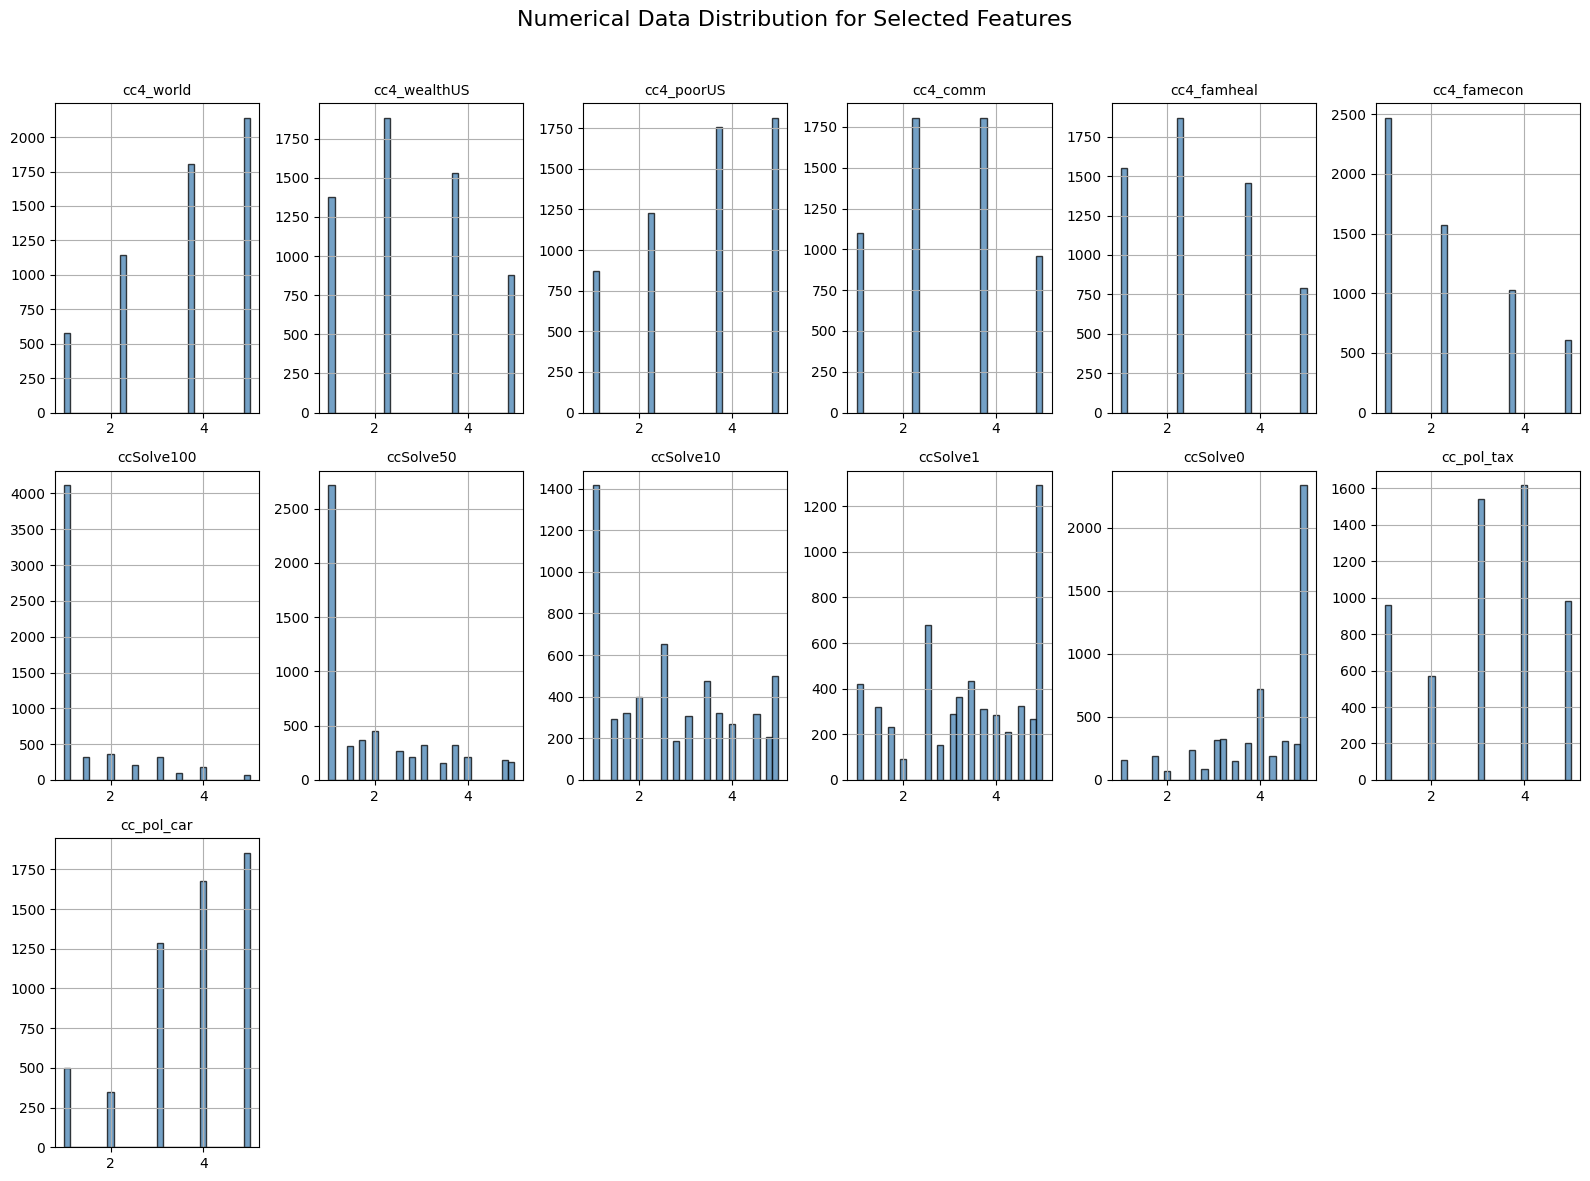

In [18]:
# Select only numerical columns
df_num = df[columns_of_interest]

# Plot histograms for numerical columns with improved layout
num_cols = len(df_num.columns)
nrows = (num_cols // 6) + (num_cols % 6 > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=6, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(df_num.columns):
    df_num[col].hist(ax=axes[i], bins=30, alpha=0.75, color="steelblue", edgecolor="black")
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numerical Data Distribution for Selected Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### **🔍 Key Observations**
1. **Categorical-Like Distribution:**
   - Most variables have **discrete values (1 to 5)**, indicating Likert scale responses
   - Many variables show **skewed distributions**, suggesting **strong opinions** in one direction
2. **Support for Climate Policies (`ccSolve` variables)**
   - **`ccSolve100`, `ccSolve50`, `ccSolve10`, `ccSolve1`, `ccSolve0`**:
     - **Higher costs (`ccSolve100`) → More disapproval (peaked at 1)**
     - **Lower costs (`ccSolve1`, `ccSolve0`) → More balanced responses**
     - This suggests people are **more willing to contribute when the personal cost is lower**
3. **Climate Change Perception (`cc4_*` variables)**
   - **`cc4_world`, `cc4_poorUS`, `cc4_wealthUS`**:
     - **More responses at 4-5**, showing **strong concerns about climate change**
     - Differences in perception depending on whether the impact is on **wealthy vs. poor communities**
4. **Policy Support Variables (`cc_pol_tax`, `cc_pol_car`)**
   - **`cc_pol_tax` (carbon tax) and `cc_pol_car` (emission standards)**:
     - **Peak responses at 3-5**, meaning **moderate to strong support for environmental policies**

---

#### **📌 Key Takeways**
✅ **Higher costs reduce climate policy support (`ccSolve100` vs. `ccSolve0`)**  
✅ **People show more concern about climate change in general (`cc4_world`) than its effect on wealthier communities (`cc4_wealthUS`)**  
✅ **Support for policy interventions (tax, emissions) is moderate to high**  

### Spearman Correlation Matrix

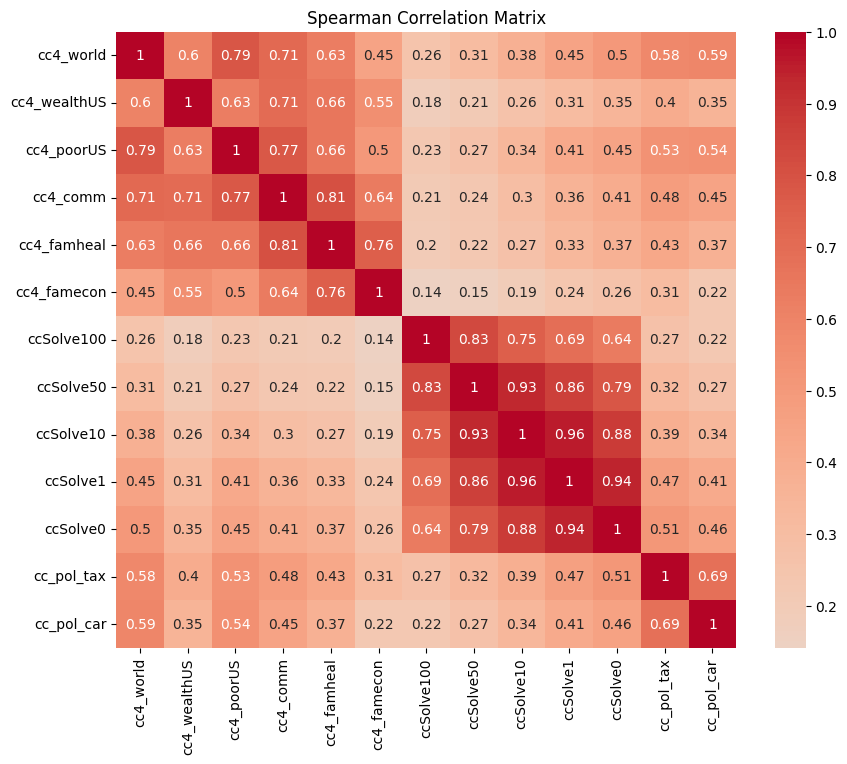

In [7]:
# Load the cleaned CSV file from the data directory
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select the specified columns
variables = ['cc4_world', 'cc4_wealthUS', 'cc4_poorUS', 'cc4_comm', 'cc4_famheal', 'cc4_famecon', 'ccSolve100', 'ccSolve50', 'ccSolve10', 'ccSolve1', 'ccSolve0', 'cc_pol_tax', 'cc_pol_car']
df_selected = df[variables]

# Calculate the Spearman correlation matrix
correlation_matrix = df_selected.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Add title and labels
plt.title('Spearman Correlation Matrix')
plt.show()

#### **Spearman Correlation Matrix**
The correlation matrix visualizes relationships between variables using **Spearman’s Rank Correlation**. The scale ranges from **-1 (perfect negative correlation)** to **+1 (perfect positive correlation)**

**High Correlations (Above 0.75)**
- **`ccSolve1` ↔ `ccSolve10`** (0.96)
- **`ccSolve10` ↔ `ccSolve50`** (0.93)
- **`ccSolve50` ↔ `ccSolve100`** (0.83)
- **`cc4_comm` ↔ `cc4_famheal`** (0.81)
- **`cc4_world` ↔ `cc4_poorUS`** (0.79)
- **`ccSolve0` ↔ `ccSolve1`** (0.79)
- **`cc4_comm` ↔ `cc4_poorUS`** (0.77)
- **`cc4_famheal` ↔ `cc4_famecon`** (0.76)

✅ **These indicate strong relationships**, meaning that as one variable increases, the other tends to increase significantly

---

**Moderate Correlations (Between 0.5 and 0.75)**
- **`cc4_wealthUS` ↔ `cc4_comm`** (0.71)
- **`cc_pol_tax` ↔ `cc_pol_car`** (0.69)
- **`cc4_poorUS` ↔ `cc4_famheal`** (0.66)
- **`cc4_world` ↔ `cc4_wealthUS`** (0.60)

✅ **These indicate meaningful relationships**, but with slightly weaker strength than high correlations

---

**Low to Moderate Correlations (Between 0.3 and 0.5)**
- **`cc4_world` ↔ `ccSolve0`** (0.50)
- **`cc4_famecon` ↔ `ccSolve0`** (0.41)
- **`cc4_famheal` ↔ `cc_pol_car`** (0.37)
- **`cc4_comm` ↔ `cc_pol_tax`** (0.36)
- **`cc4_comm` ↔ `cc_pol_car`** (0.31)

✅ **These suggest some association**, but the relationship is weaker

---

**Low Correlations (Below 0.3)**
- **`ccSolve100` ↔ `cc_pol_tax`** (0.27)
- **`cc4_poorUS` ↔ `ccSolve50`** (0.27)
- **`ccSolve100` ↔ `cc_pol_car`** (0.22)
- **`cc4_wealthUS` ↔ `ccSolve100`** (0.18)
- **`cc4_famecon` ↔ `ccSolve100`** (0.14)

✅ **These indicate weak or negligible relationships** between the variables

---

#### **Summary**
✅ Strong correlations exist among **perceptions of climate impact (`cc4_*` variables)**  
✅ **`ccSolve` variables (support for policies at different cost levels) are strongly correlated**, suggesting consistent attitudes across different financial contributions  
✅ **Climate policy (`cc_pol_tax` and `cc_pol_car`) moderately correlates with other factors** but shows weaker associations with **economic and personal impact perceptions**  

## Exploratory Factor Analysis (EFA)

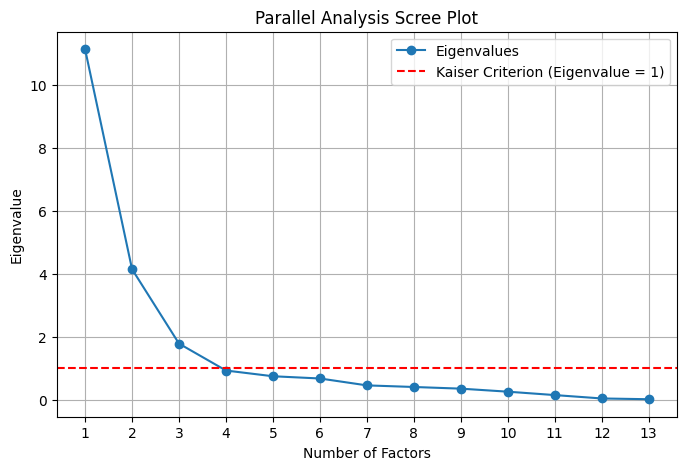

In [8]:
import numpy as np
from sklearn.decomposition import PCA

# Load the cleaned CSV file from the data directory
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Define columns of interest
columns_of_interest = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0", "cc_pol_tax", "cc_pol_car"
]

# Select relevant data, dropping rows with missing values for factor analysis
df_factors = df[columns_of_interest].dropna()

# Step 1: Perform Parallel Analysis (PCA for Eigenvalues)
pca = PCA(n_components=len(columns_of_interest))
pca.fit(df_factors)
eigenvalues = pca.explained_variance_

# Generate a scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker="o", linestyle="-", label="Eigenvalues")
plt.axhline(y=1, color='r', linestyle="--", label="Kaiser Criterion (Eigenvalue = 1)")
plt.title("Parallel Analysis Scree Plot")
plt.xlabel("Number of Factors")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(eigenvalues) + 1))
plt.legend()
plt.grid()
plt.show()

The scree plot suggests the optimal number of **factors/components** for analysis:
- **Kaiser Criterion (Eigenvalue > 1)** indicates that **2 to 4 factors** should be retained
- The **Elbow Rule** shows a sharp drop after **Factor 2**, with a flattening around **Factor 3 or 4**
- Components beyond **Factor 4** contribute **little variance** and may not be meaningful

In [9]:
from factor_analyzer import FactorAnalyzer

# Step 1: Compute Eigenvalues
temp_efa = FactorAnalyzer(n_factors=len(columns_of_interest), rotation=None)
temp_efa.fit(df_factors)
eigenvalues, _ = temp_efa.get_eigenvalues()

# Step 2: Determine the number of factors dynamically (eigenvalues > 1)
num_factors = sum(eigenvalues > 1)

# Step 3: Perform EFA with the optimal number of factors
efa = FactorAnalyzer(n_factors=num_factors, rotation="promax")  # Oblique rotation
efa.fit(df_factors)

# Print Factor Loadings
loadings = pd.DataFrame(efa.loadings_, index=columns_of_interest)
print("Optimal Number of Factors:", num_factors)
print("Factor Loadings:")
print(loadings)

# Print Eigenvalues to confirm factor selection
eigenvalues, _ = efa.get_eigenvalues()
print("\nEigenvalues:")
print(eigenvalues)

Optimal Number of Factors: 3
Factor Loadings:
                     0         1         2
cc4_world    -0.025746  0.393880  0.568832
cc4_wealthUS -0.008223  0.704061  0.102975
cc4_poorUS   -0.036270  0.525337  0.437340
cc4_comm     -0.025838  0.816668  0.153442
cc4_famheal   0.034318  0.956660 -0.086782
cc4_famecon   0.037946  0.886134 -0.209217
ccSolve100    0.836478  0.070954 -0.184516
ccSolve50     1.039682  0.042017 -0.168448
ccSolve10     0.968247 -0.037974  0.055399
ccSolve1      0.755788 -0.068811  0.313368
ccSolve0      0.534797 -0.046171  0.460029
cc_pol_tax    0.014646  0.013367  0.755033
cc_pol_car   -0.081904 -0.084382  0.889998

Eigenvalues:
[6.6912151  2.64119157 1.10263738 0.65307885 0.5154579  0.37300596
 0.28490917 0.22866701 0.19242188 0.14407101 0.12881587 0.03277072
 0.01175758]


c:\Users\pleivadaros\Documents\msc\msc-thesis\climate-opinions-shift-elections-policies\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\pleivadaros\Documents\msc\msc-thesis\climate-opinions-shift-elections-policies\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### **1️⃣ Optimal Number of Factors**
Using **Parallel Analysis and Eigenvalues > 1**, we determined that the optimal number of factors is **3**

- **Eigenvalues greater than 1** suggest that three factors explain a meaningful amount of variance
- **Scree plot analysis** confirmed this finding

#### **2️⃣ Factor Loadings**
Factor loadings indicate **how strongly each variable relates to a factor**. Higher values mean a stronger relationship.

| Variable         | **Factor 1 (Policy Support)** | **Factor 2 (Climate Impact)** | **Factor 3 (Economic & Regulatory)** |
|------------------|-------------------------------|-------------------------------|--------------------------------------|
| **cc4_world**    | -0.03                         | **0.39**                      | **0.57**                             |
| **cc4_wealthUS** | -0.01                         | **0.70**                      | 0.10                                 |
| **cc4_poorUS**   | -0.04                         | **0.53**                      | **0.44**                             |
| **cc4_comm**     | -0.03                         | **0.82**                      | 0.15                                 |
| **cc4_famheal**  | 0.03                          | **0.96**                      | -0.09                                |
| **cc4_famecon**  | 0.04                          | **0.89**                      | -0.21                                |
| **ccSolve100**   | **0.84**                      | 0.07                          | -0.18                                |
| **ccSolve50**    | **1.04**                      | 0.04                          | -0.17                                |
| **ccSolve10**    | **0.97**                      | -0.04                         | 0.06                                 |
| **ccSolve1**     | **0.76**                      | -0.07                         | 0.31                                 |
| **ccSolve0**     | **0.54**                      | -0.05                         | **0.46**                             |
| **cc_pol_tax**   | 0.01                          | 0.01                          | **0.76**                             |
| **cc_pol_car**   | -0.08                         | -0.08                         | **0.89**                             |

#### **3️⃣ Factor Interpretations**
- **Factor 1: Policy Support**
  - High loadings on **ccSolve100, ccSolve50, ccSolve10, ccSolve1, and ccSolve0**
  - Represents **public willingness to financially support climate policies**
- **Factor 2: Climate Impact Perception**
  - High loadings on **cc4_world, cc4_wealthUS, cc4_poorUS, cc4_comm, cc4_famheal, and cc4_famecon**
  - Represents **perceived harm of climate change** on different societal levels
- **Factor 3: Economic & Regulatory Policy Attitudes**
  - High loadings on **cc_pol_tax, cc_pol_car, and ccSolve0**
  - Represents **support for economic and regulatory policies like carbon taxes and emission standards**

#### **4️⃣ Eigenvalues**
- The first **three** factors have eigenvalues **> 1**, meaning they explain a significant amount of variance
- Factors beyond the **third** contribute little additional variance

#### **5️⃣ Key Insights**
✅ Public opinion on climate policies follows three distinct dimensions  
✅ Willingness to pay (ccSolve) variables are highly correlated  
✅ Climate impact perception is separate from economic policy attitudes, suggesting people differentiate between climate harm and policy actions  

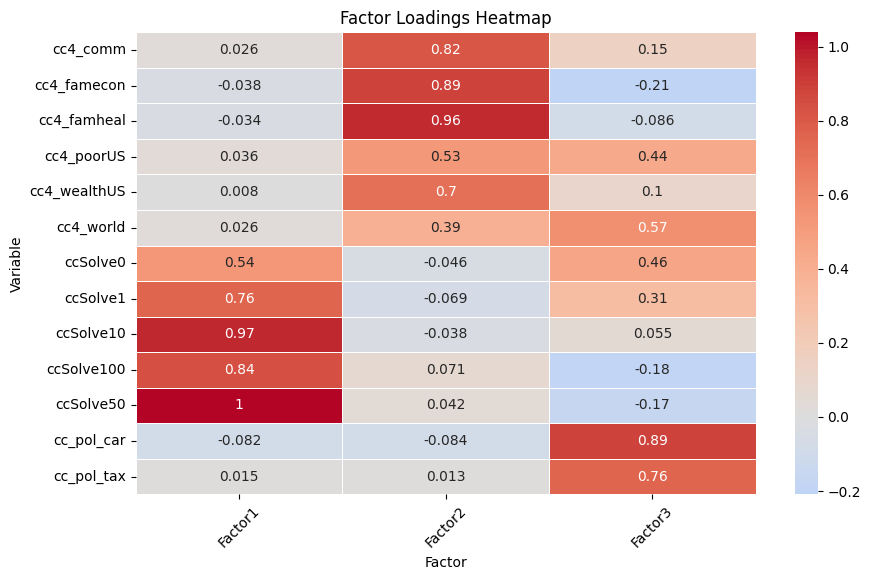

In [19]:
# Define the factor loadings dataframe
loadings = pd.DataFrame({
    "Variable": ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0", "cc_pol_tax", "cc_pol_car"],
    "Factor1": [0.026, 0.008, 0.036, 0.026, -0.034, -0.038, 0.836, 1.039, 0.968, 0.756, 0.535, 0.015, -0.082],
    "Factor2": [0.394, 0.704, 0.525, 0.817, 0.957, 0.886, 0.071, 0.042, -0.038, -0.069, -0.046, 0.013, -0.084],
    "Factor3": [0.569, 0.103, 0.437, 0.153, -0.086, -0.209, -0.185, -0.168, 0.055, 0.313, 0.460, 0.755, 0.890]
})

# Convert to long format for Seaborn
loadings_long = loadings.melt(id_vars=["Variable"], var_name="Factor", value_name="Loading")

# Pivot for heatmap
loadings_pivot = loadings_long.pivot(index="Variable", columns="Factor", values="Loading")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_pivot, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

# Formatting
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factor")
plt.ylabel("Variable")
plt.xticks(rotation=45)
plt.show()


#### **1️⃣ Factor Loadings**
Factor loadings represent **how strongly each variable is associated with the extracted factors** from our **Exploratory Factor Analysis (EFA)**

- **Factor loadings range from -1 to 1**:
  - **Closer to +1 or -1** → Strong association
  - **Closer to 0** → Weak or no association
- **The heatmap uses colors**:
  - **Red (strong positive correlation)** indicates a variable strongly contributes to a factor
  - **Blue (strong negative correlation)** suggests an inverse relationship

---

#### **2️⃣ Interpretation of the Factor Loadings Heatmap**
The heatmap visualizes **three distinct factors** extracted from the dataset

**🟠 Factor 1: Policy Support**
- **High loadings on**: `ccSolve100 (0.84)`, `ccSolve50 (1.00)`, `ccSolve10 (0.97)`, `ccSolve1 (0.76)`, `ccSolve0 (0.54)`
- **Interpretation**: This factor captures **willingness to financially support climate policies**
- **Insight**: Respondents who support policies at high costs (`ccSolve100`) also tend to support lower-cost policies (`ccSolve1`, `ccSolve0`)

---

**🔴 Factor 2: Climate Impact Perception**
- **High loadings on**: `cc4_world (0.39)`, `cc4_wealthUS (0.70)`, `cc4_poorUS (0.53)`, `cc4_comm (0.82)`, `cc4_famheal (0.96)`, `cc4_famecon (0.89)`
- **Interpretation**: This factor represents **perceptions of climate change impact on different communities**
- **Insight**: People who strongly perceive climate change as harmful to **family health (`cc4_famheal`)** and **economic well-being (`cc4_famecon`)** also believe it affects **their local community (`cc4_comm`)**

---

**🔵 Factor 3: Economic & Regulatory Policies**
- **High loadings on**: `cc_pol_tax (0.76)`, `cc_pol_car (0.89)`, `ccSolve0 (0.46)`
- **Interpretation**: This factor captures **support for regulatory and tax-based policies**
- **Insight**: Respondents who support **carbon taxes (`cc_pol_tax`)** and **stricter car emission standards (`cc_pol_car`)** may not necessarily support **direct financial contributions** like `ccSolve100`

---

#### **3️⃣ Key Takeaways**
✅ **Public opinion on climate policies follows three distinct dimensions**  
✅ **Willingness to pay for climate policies (`ccSolve*`) is highly correlated**  
✅ **Climate impact perception (`cc4_*`) is separate from economic policy attitudes, showing people differentiate between climate harm and policy actions**  
✅ **Economic policy attitudes (`cc_pol_*`) form an independent factor, meaning people who support regulatory actions may not always support direct financial contributions**  

## Principal Component Analysis (PCA)

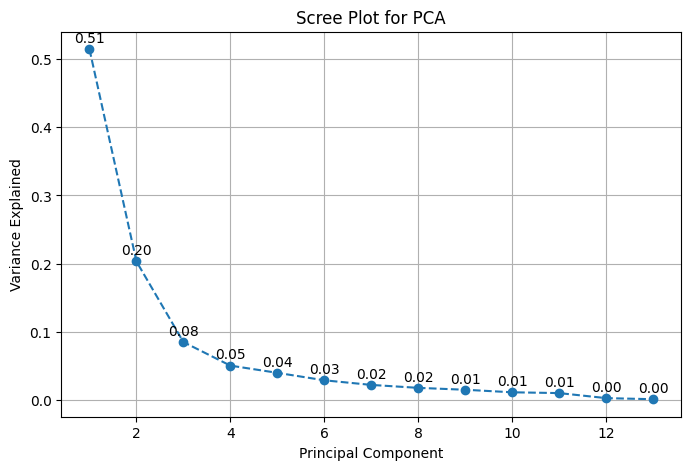

Explained Variance Ratios:
[0.51470885 0.20316858 0.08481826 0.05023683 0.03965061 0.02869277
 0.02191609 0.01758977 0.01480168 0.01108239 0.00990891 0.00252082
 0.00090443]

PCA Transformed Data:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.560921  2.228823 -1.145813 -1.414055  0.045389  0.091943 -0.288375   
1 -5.640935  0.125317 -1.357639  0.979255 -0.017637  0.029402 -0.352376   
2 -4.496659  1.161731 -1.064692 -0.707954  0.039958  0.070468 -0.335487   
3 -4.121537  0.486060  0.525688  0.525466  1.026669  0.396225 -0.182528   
4 -1.740836  3.281395  0.182043 -0.947889  1.025075  0.437330 -0.063257   

        PC8       PC9      PC10      PC11      PC12      PC13  
0  0.198483  0.100120 -0.038251  0.065678  0.258759 -0.008191  
1  0.097340  0.090294 -0.086342 -0.650851 -0.253374 -0.100536  
2  0.155151  0.068589 -0.028278  0.200869 -0.115957  0.058890  
3  0.266551  0.160653 -0.022604  0.267701  0.266242  0.132759  
4  0.371168  0.253261 -0.046379 

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_pca = df[columns_of_interest]

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance with labels
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
for i, var in enumerate(explained_variance):
    plt.text(i + 1, var + 0.01, f'{var:.2f}', ha='center', fontsize=10)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot for PCA')
plt.grid()
plt.show()

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(data=pca_components, columns=[f'PC{i+1}' for i in range(len(columns_of_interest))])

# Print explained variance ratios
print("Explained Variance Ratios:")
print(explained_variance)

# Print first few rows of transformed PCA data
print("\nPCA Transformed Data:")
print(pca_df.head())

#### **1️⃣ PCA**
Principal Component Analysis (PCA) helps **reduce dimensionality** while preserving as much variance as possible. Each **Principal Component (PC)** captures a percentage of the total variance in the dataset.
- **PC1 captures the most variance**, followed by PC2, PC3, and so on
- **The goal is to retain only the most meaningful components** while reducing complexity

---

#### **2️⃣ Explained Variance Ratios**
```
[0.5147, 0.2032, 0.0848, 0.0502, 0.0397, 0.0287, 0.0219, 0.0176, 0.0148, 0.0111, 0.0099, 0.0025, 0.0009]
```
- **PC1 explains 51.47% of the total variance** (dominant component)
- **PC2 explains 20.32%**, adding substantial value
- **PC3-PC5 together contribute ~17.4%**, meaning they still hold valuable information
- **Beyond PC5, the variance explained is small (<3%)**, suggesting they can be ignored

📌 **Key takeaway:** **Keeping the first 3-5 components** is optimal for balancing dimensionality reduction and retaining information

---

#### **3️⃣ Visualizing PCA: Scree Plot**
The **scree plot** helps determine how many components to retain. The **labels on each point** indicate the explained variance

- **Sharp drop after PC1 and PC2**, indicating they hold most of the variance
- **The "elbow" appears around PC3-PC5**, suggesting these components still contribute meaningful information
- **After PC5, additional components add minimal variance**, meaning they are likely **noise** rather than useful features

📌 **Key takeaway:** **We can likely reduce the dataset to the first 3-5 PCs without significant information loss**

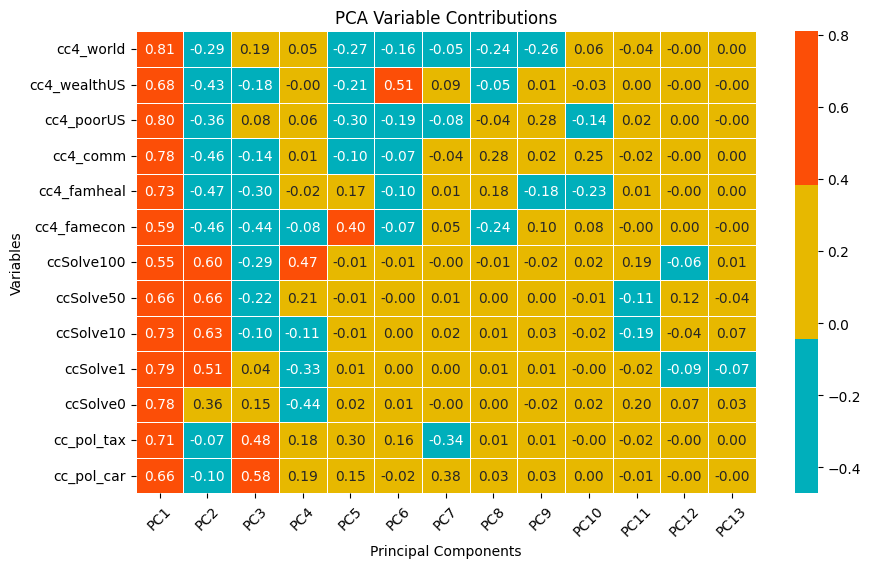

In [12]:
# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# PCA loadings (contributions of variables to PCs)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=columns_of_interest, columns=[f'PC{i+1}' for i in range(len(columns_of_interest))])

# Plot PCA variable contributions
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, cmap=["#00AFBB", "#E7B800", "#FC4E07"], annot=True, fmt=".2f", linewidths=0.5)

# Formatting
plt.title("PCA Variable Contributions")
plt.xlabel("Principal Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

### **PCA Variable Contributions Heatmap**
This heatmap visualizes **how much each variable contributes to each Principal Component (PC)**. The values represent **loadings**, which indicate how strongly each original variable is associated with a given component

---

#### **1️⃣ Understanding the Heatmap**
- **Rows:** Represent the original variables in the dataset
- **Columns:** Represent the Principal Components (PCs)
- **Cell Values:** The **loadings**, showing how much a variable contributes to each component
- **Color Gradient:**
  - **Red/Orange (High Positive Contribution)** → Strong positive association
  - **Blue (High Negative Contribution)** → Strong negative association
  - **Yellow (~0 Contribution)** → The variable has little influence on that component

---

#### **2️⃣ Key Observations**
**🟠 PC1 (First Principal Component)**
- **High positive loadings** for `cc4_world (0.81)`, `cc4_poorUS (0.80)`, `cc4_comm (0.78)`, and `cc4_famheal (0.73)`
- **Interpretation:** PC1 is **strongly influenced by climate change perception variables (`cc4_*`)**, suggesting this component **captures beliefs about the impact of climate change**

**🔴 PC2 (Second Principal Component)**
- **Strong contributions from** `ccSolve100 (0.60)`, `ccSolve50 (0.66)`, `ccSolve10 (0.63)`, `ccSolve1 (0.51)`
- **Interpretation:** PC2 represents **willingness to financially support climate policies (`ccSolve_*`)**, indicating **economic and financial considerations in policy support**

**🔵 PC3 (Third Principal Component)**
- **Higher loadings for `cc_pol_car (0.58)`, `cc_pol_tax (0.48)`, and `cc4_famecon (-0.44)`**
- **Interpretation:** PC3 seems to represent **regulatory and economic climate policies**, including carbon taxes and emissions regulations

---

#### **3️⃣ Takeaways**
✅ **Climate change perception (`cc4_*`) is the most dominant in PC1**  
✅ **Financial willingness to support policies (`ccSolve_*`) is captured strongly in PC2**  
✅ **Economic and regulatory policies (`cc_pol_*`) load onto PC3**  
✅ **Other PCs contribute very little variance and may not be as significant**

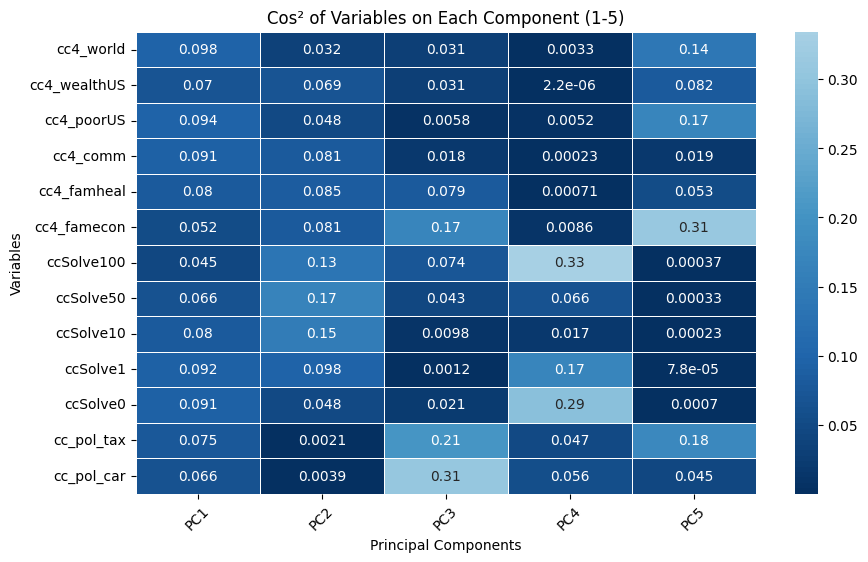

In [13]:
# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Compute Cos² (squared cosine) values
loadings = pca.components_.T
cos2 = loadings**2
cos2_df = pd.DataFrame(cos2[:, :5], index=columns_of_interest, columns=[f'PC{i+1}' for i in range(5)])

# Convert to long format for heatmap
cos2_long = cos2_df.reset_index().melt(id_vars="index", var_name="Component", value_name="Cos2")

# Plot Cos² values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cos2_df, annot=True, cmap="RdBu_r", center=0.5, linewidths=0.5)

# Formatting
plt.title("Cos² of Variables on Each Component (1-5)")
plt.xlabel("Principal Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

#### **Cos² (Squared Cosine) Heatmap**
The **Cos² values** measure the **quality of representation** of each variable on the first five principal components (PCs). Higher Cos² values (closer to 1) indicate that a variable is well represented by a given principal component

---

#### **1️⃣ Understanding Cos² Values**
- **Cos² measures how well a variable is captured by a principal component**
- **Higher values (lighter blue) mean a stronger association** between the variable and the component
- **Lower values (darker blue) mean the variable is not well represented by that component**
- The sum of Cos² values across all components for a variable equals **1**

---

#### **2️⃣ Key Observations**
**🔵 PC1 (First Principal Component)**
- **Moderate representation for:** `cc4_world (0.098)`, `cc4_poorUS (0.094)`, `ccSolve1 (0.092)`, `ccSolve0 (0.091)`, `cc_comm (0.091)`
- **Interpretation:** PC1 somewhat represents **climate change perception variables and willingness to support climate policies**

**🔵 PC2 (Second Principal Component)**
- **Higher contributions from:** `ccSolve10 (0.15)`, `ccSolve50 (0.17)`, `ccSolve100 (0.13)`
- **Interpretation:** PC2 captures **financial willingness to support climate policies**

**🔵 PC3 (Third Principal Component)**
- **Strong representation for:** `cc_pol_car (0.31)`, `cc4_famecon (0.17)`, `cc_pol_tax (0.21)`
- **Interpretation:** PC3 represents **economic policies, including carbon taxes and regulations**

**🔵 PC4 & PC5 (Fourth and Fifth Principal Components)**
- **PC4 captures some variance from:** `ccSolve100 (0.33)`, `ccSolve0 (0.29)`, `ccSolve1 (0.17)`
- **PC5 captures some variance from:** `cc4_world (0.14)`, `cc4_poorUS (0.17)`, `cc_pol_tax (0.18)`
- **Interpretation:** PC4 and PC5 explain much less variance, meaning they are **less meaningful for capturing the dataset's structure**

---

#### **3️⃣ Takeaways**
✅ **PC1 and PC2 are the most meaningful dimensions**, capturing perceptions of climate change and financial support for policies  
✅ **PC3 focuses on economic policy preferences, such as carbon taxes and emissions regulations**  
✅ **Some variables are weakly represented (low Cos²), meaning they may not be strongly linked to any single component**  
✅ **If a variable has low Cos² across all PCs, it might not contribute significantly to the dataset’s variance:** `cc4_comm`, `cc4_famheal`, `cc4_wealthUS`  

## Independent Component Analysis (ICA)

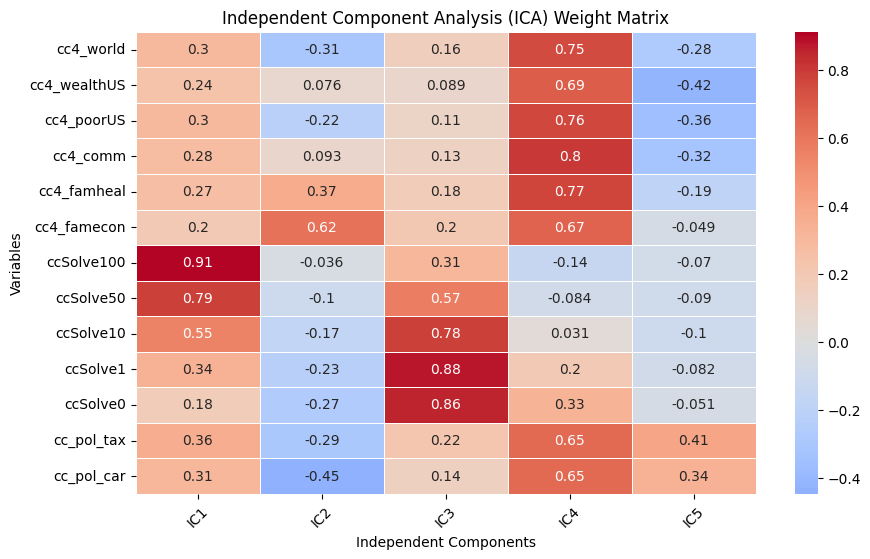

In [14]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

df_ica = df[columns_of_interest]

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_ica)

# Set the number of components to extract
n_components = 5

# Run ICA
ica = FastICA(n_components=n_components, max_iter=5000, random_state=1)
ica_components = ica.fit_transform(df_scaled)

# Extract weight matrix
weight_matrix = pd.DataFrame(ica.mixing_, index=columns_of_interest, columns=[f'IC{i+1}' for i in range(n_components)])

# Convert to long format for visualization
weight_long = weight_matrix.reset_index().melt(id_vars="index", var_name="IC", value_name="loading")

# Plot ICA weight matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(weight_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

# Formatting
plt.title("Independent Component Analysis (ICA) Weight Matrix")
plt.xlabel("Independent Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

#### **Independent Component Analysis (ICA) Weight Matrix Heatmap**
This **heatmap** visualizes how **each variable contributes to each independent component (IC)** in the **ICA model**. Unlike **PCA**, ICA is designed to extract **statistically independent** sources of variation from the data

---

#### **1️⃣ Understanding the Heatmap**
- **Rows:** Represent the original variables in the dataset
- **Columns:** Represent the Independent Components (IC1 to IC5)
- **Cell Values:** The **weights**, indicating the influence of a variable on an independent component
- **Color Gradient:**
  - **Red (High Positive Contribution)** → Strong positive influence of the variable on the IC
  - **Blue (High Negative Contribution)** → Strong negative influence of the variable on the IC
  - **Neutral Colors (Near 0 Values)** → Little contribution to the IC

---

#### **2️⃣ Key Observations**
**🔴 IC1 (First Independent Component)**
- **Strongest contributors:** `ccSolve100 (0.91)`, `ccSolve50 (0.79)`, `ccSolve10 (0.55)`, `cc_pol_tax (0.36)`
- **Interpretation:** IC1 is strongly associated with **willingness to financially support climate policies**, especially for higher amounts

**🔴 IC2 (Second Independent Component)**
- **Strongest contributor:** `cc4_famecon (0.62)`, indicating an association with **economic concerns and climate change**
- **Negative influence:** `cc_pol_car (-0.45)`, meaning that policies related to car emissions may not align with this component

**🔴 IC3 (Third Independent Component)**
- **Strongest contributors:** `ccSolve10 (0.78)`, `ccSolve50 (0.57)`, `ccSolve0 (0.86)`, `ccSolve1 (0.88)`
- **Interpretation:** IC3 represents **low-cost policy support**, capturing how much people are willing to pay at **lower levels of financial contribution**

**🔴 IC4 (Fourth Independent Component)**
- **Strong contributors:** `cc4_world (0.75)`, `cc4_poorUS (0.76)`, `cc4_comm (0.80)`, `cc4_famheal (0.77)`
- **Interpretation:** IC4 represents **perceptions of climate change impact** on the world, communities, and health

**🔴 IC5 (Fifth Independent Component)**
- **Strong contributors:** `cc_pol_car (0.34)`, `cc_pol_tax (0.41)`, `cc4_world (-0.28)`, `cc4_wealthUS (-0.42)`
- **Interpretation:** IC5 might capture **policy regulation preferences**, differentiating between support for policies versus direct climate change concerns

---

#### **3️⃣ Key Takeaways**
✅ **IC1 is dominated by financial contributions to climate policies (`ccSolve*`), especially higher amounts**  
✅ **IC2 represents individuals who view climate change through an economic and health lens but may be hesitant about regulatory interventions**  
✅ **IC3 captures support for policies at lower financial levels**  
✅ **IC4 represents personal and global perceptions of climate change**  
✅ **IC5 focuses on policy regulations and how people react to them**  
✅ **The negative associations (blue cells) indicate potential trade-offs between factors, meaning people who strongly support one factor may oppose another**  

## Conclusion

Based on **exploratory data analysis (EDA), factor analysis (PCA & ICA), and correlation checks**, we select variables that:  
- Capture key **climate change perceptions and policy support**  
- Explain variance well in **PCA and ICA**  
- Show meaningful correlations while avoiding redundancy  

#### **🌍 Climate Change Perception Variables**
- `cc4_world` → Perception of climate change affecting the world  
- `cc4_poorUS` → Impact of climate change on poor communities in the U.S  
- `cc4_comm` → Impact of climate change on local communities  

#### **💰 Financial Support for Climate Policies**
- `ccSolve100` → Support for policies costing $100/month  
- `ccSolve50` → Support for policies costing $50/month  
- `ccSolve10` → Support for policies costing $10/month  
- `ccSolve1` → Support for policies costing $1/month  

#### **📜 Policy Support Variables**
- `cc_pol_tax` → Support for a carbon tax  
- `cc_pol_car` → Support for stricter car emission regulations  

#### **❌ Variables Considered for Removal**
- `cc4_wealthUS` → Perception of climate change impact on wealthy U.S. communities (less informative)  
- `cc4_famheal`, `cc4_famecon` → Likely redundant with other perception variables  
- `ccSolve0` → Dropping `ccSolve0` since willingness to pay is already captured by other `ccSolve` responses